In [1]:
import os
import gc
import glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import utils

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import roc_auc_score, roc_curve, auc

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm
import pickle

np.random.seed(7)
torch.manual_seed(7)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
def img_paths_list(root_dir):
    root_list = glob.glob(root_dir)
    class_map = {}
    class_distribution = {}
    
    for img_path in root_list:
        class_name = img_path.split(os.sep)[-2]
        if class_name not in class_distribution:
            class_distribution[class_name] = 1
        else:
            class_distribution[class_name] +=1
                
    for index, entity in enumerate(class_distribution):
        class_map[entity] = index
    print("Dataset Distribution:\n")
    print(class_distribution)
    print("\n\nClass indices:\n")
    print(class_map)

    data = []
    for img_path in tqdm(root_list):
        class_name = img_path.split(os.sep)[-2]
        data.append([img_path, class_name])
        
    return data, class_map

In [3]:
data_root_dir = r'../input/gsocml4scimodel1/Model_I/*/*'
dataset_img_paths_list, class_map = img_paths_list(data_root_dir)

Dataset Distribution:

{'axion': 28897, 'no_sub': 28856, 'cdm': 29772}


Class indices:

{'axion': 0, 'no_sub': 1, 'cdm': 2}


  0%|          | 0/87525 [00:00<?, ?it/s]

In [4]:
def data_split(img_paths):
    X = []
    y = []
    for img_path in img_paths:
        X.append(img_path[0])
        y.append(img_path[1])
    
    X_train_list, X_test_list, y_train_list, y_test_list = TTS(X, y, stratify = y, test_size=0.1)
    
    train_img_paths = []
    test_img_paths = []
    for i in range(0, len(X_train_list)):
        train_img_paths.append([X_train_list[i], y_train_list[i]])
    for i in range(0, len(X_test_list)):
        test_img_paths.append([X_test_list[i], y_test_list[i]])
        
    return train_img_paths, test_img_paths

In [5]:
train_set_image_paths_list , test_set_image_paths_list = data_split(dataset_img_paths_list)
print(len(train_set_image_paths_list), len(test_set_image_paths_list))

78772 8753


In [6]:
def pickelize_file(dicto, pickle_path):
    file_to_write = open(pickle_path, "wb")
    pickle.dump(dicto, file_to_write)
    
    print("Pickleized successfully!")

In [7]:
pickelize_file(train_set_image_paths_list, "train_set_image_paths_list.pickle")
pickelize_file(test_set_image_paths_list, "test_set_image_paths_list.pickle")

Pickleized successfully!
Pickleized successfully!


In [8]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_and_labels_list, class_map,transform = None):
        self.data = img_paths_and_labels_list
        self.class_map = class_map
        self.transform = transform
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = np.load(img_path, allow_pickle = True)
        if class_name == 'axion':
            img = img[0]
        
#         img = np.expand_dims(img, axis = 0)
        
        if self.transform:
            aug = self.transform(image=img)
            img = aug['image']
        
        img = img.to(torch.float)
        class_id = self.class_map[class_name]
        class_id = torch.tensor(class_id)

        return img, class_id

In [9]:
 transforms = A.Compose(
            [
                A.CenterCrop(height = 100, width = 100, p=1.0),
                ToTensorV2()
            ]
        )

In [10]:
#Using a batch size of 128
BS = 64

In [11]:
train_dataset = CustomDataset(train_set_image_paths_list, class_map, transform = transforms)
print(len(train_dataset))


test_set = CustomDataset(test_set_image_paths_list, class_map, transform = transforms)
print(len(test_set))

78772
8753


In [12]:
m = len(train_dataset)
test_split_size = 0.1

print("Total training data: " + str(m))

try:
    train_set,val_set=random_split(train_dataset,[int(m-m*test_split_size),int(m*test_split_size)])
except:
    train_set,val_set=random_split(train_dataset,[int(m-m*test_split_size),int(m*test_split_size+1)])
    
len(train_set), len(val_set), len(test_set)

Total training data: 78772


(70894, 7878, 8753)

In [13]:
train_loader = DataLoader(train_set, batch_size = BS, shuffle = True)
val_loader = DataLoader(val_set, batch_size = BS, shuffle = False)
test_loader = DataLoader(test_set, batch_size = BS, shuffle = False)

In [14]:
single_batch = next(iter(train_loader))
single_batch[0].shape

torch.Size([64, 1, 100, 100])

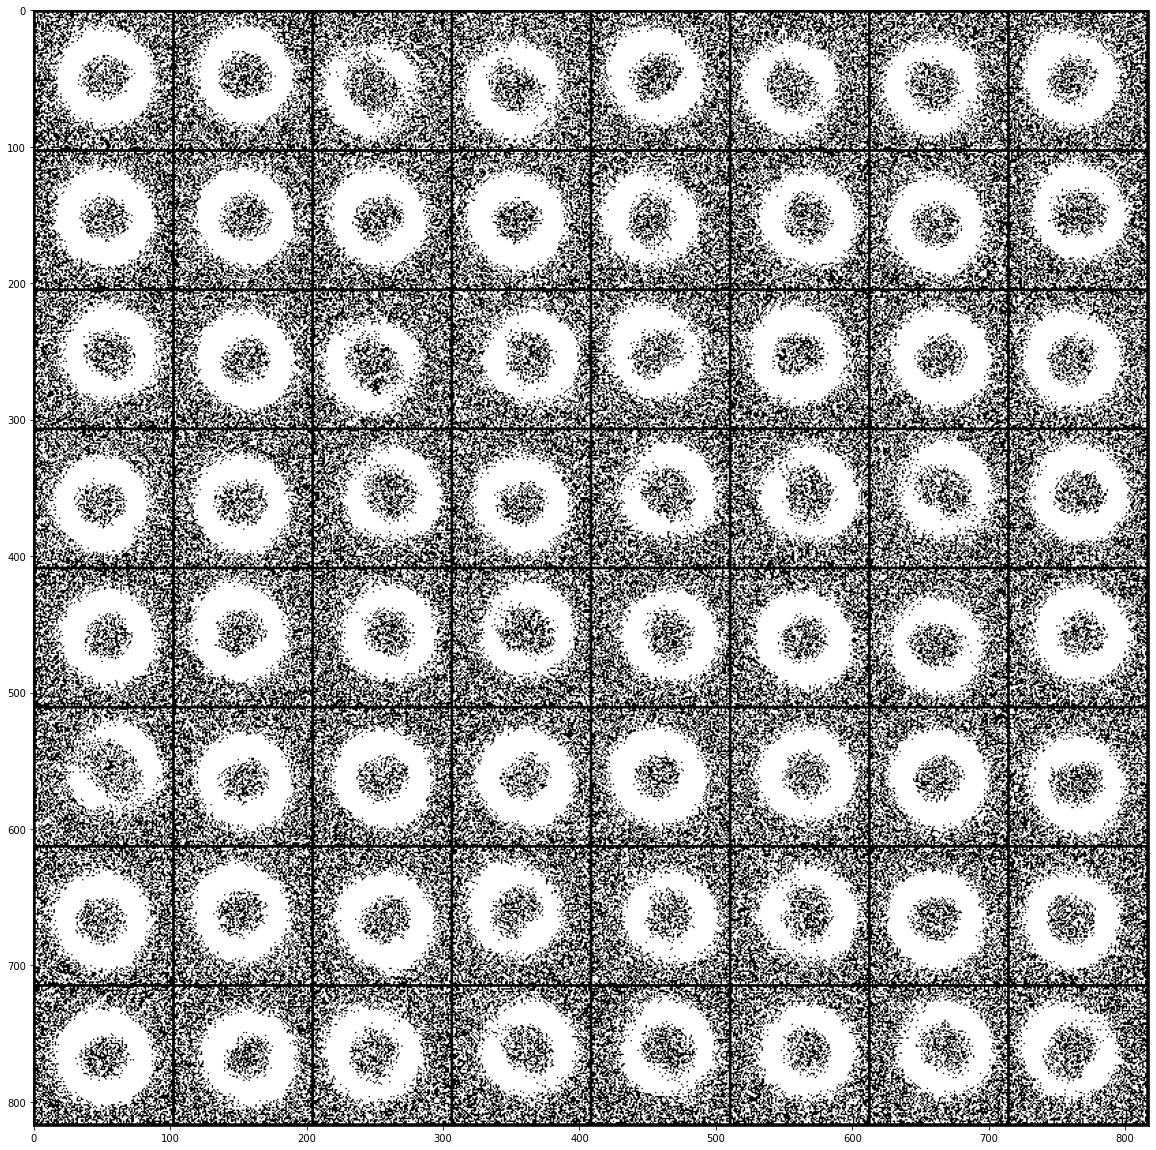

In [15]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=8)
plt.figure(figsize = (20,70))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [16]:
class pre_trained_model(nn.Module):
    
    def __init__(self, pretrained = True):
        super().__init__()
        self.model = timm.create_model('inception_resnet_v2',pretrained = pretrained, in_chans = 1)
#         num_in_features = self.model.get_classifier().in_features
        
        for param in self.model.parameters():
            param.requires_grad = True            
        
        self.fc = nn.Sequential(
                                nn.Linear(1536 * 1 * 1, 1024),
                                nn.PReLU(),
                                nn.BatchNorm1d(1024),
                                nn.Dropout(p = 0.5),
                                
                                nn.Linear(1024, 512),
                                nn.BatchNorm1d(512),
                                nn.PReLU(),
                                nn.Dropout(p = 0.5),
        
                                nn.Linear(512, 128),
                                nn.PReLU(),
                                nn.BatchNorm1d(128),
                                nn.Dropout(p = 0.3),
                                
                                nn.Linear(128, 3)
                                )
        
    def forward(self, x):
        x = self.model.forward_features(x)
        x = x.view(-1, 1536 * 1 * 1)
        x = self.fc(x)
        return x

In [17]:
model = pre_trained_model()

x = torch.randn(64, 1, 100, 100)
print(model(x).shape)

del model
gc.collect()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/inception_resnet_v2-940b1cd6.pth" to /root/.cache/torch/hub/checkpoints/inception_resnet_v2-940b1cd6.pth


torch.Size([64, 3])


23

In [18]:
def calculate_accuracy(y_pred, y_truth):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_labels = torch.max(y_pred_softmax, dim = 1)
    
    correct_preds = (y_pred_labels == y_truth).float()
    acc = correct_preds.sum() / len(correct_preds)
    acc = torch.round(acc*100)
    
    return acc  

In [19]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = []
    train_accuracy = []

    loop=tqdm(enumerate(dataloader),total = len(dataloader))

    for batch_idx, (img_batch,labels) in loop:

        X = img_batch.to(device)
        y_truth = labels.to(device)
        
        #forward prop
        y_pred = model(X)
        
        #loss and accuracy calculation
        loss = criterion(y_pred, y_truth)
        accuracy = calculate_accuracy(y_pred, y_truth)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #batch loss and accuracy
        # print(f'Partial train loss: {loss.data}')
        train_loss.append(loss.detach().cpu().numpy())
        train_accuracy.append(accuracy.detach().cpu().numpy())

    return model, np.mean(train_loss), np.mean(train_accuracy)

In [20]:
def val_epoch(model, dataloader,criterion):
    model.eval()
    val_loss = []
    val_accuracy = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)

            #forward prop
            y_pred = model(X)

            #loss and accuracy calculation
            loss = criterion(y_pred, y_truth)
            accuracy = calculate_accuracy(y_pred, y_truth)


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            val_loss.append(loss.detach().cpu().numpy())
            val_accuracy.append(accuracy.detach().cpu().numpy())
            
    return np.mean(val_loss), np.mean(val_accuracy)

In [21]:
def fit_model(model,criterion,optimizer):
    loss_dict = {'train_loss':[],'val_loss':[]}
    acc_dict = {'train_accuracy':[],'val_accuracy':[]}
    
    scheduler = CosineAnnealingWarmRestarts(optimizer,T_0 = 10, T_mult = 1,eta_min = 1e-6, verbose=True)
    
#     scheduler = ReduceLROnPlateau(optimizer, 'min',patience=2,factor=0.3,verbose=True)


    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}:")
        model, train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = val_epoch(model, val_loader, criterion)
        scheduler.step()

        print(f'Train loss:{train_loss}, Val loss:{val_loss}')
        loss_dict['train_loss'].append(train_loss)
        loss_dict['val_loss'].append(val_loss)
        print(f'Train accuracy: {train_accuracy}, Val accuracy:{val_accuracy}')
        acc_dict['train_accuracy'].append(train_accuracy)
        acc_dict['val_accuracy'].append(val_accuracy)


    return model, loss_dict, acc_dict

In [22]:
model = pre_trained_model().to(device)

criterion = nn.CrossEntropyLoss()
EPOCHS = 20
LR = 3e-4

optimizer = optim.Adam(model.parameters(),lr=LR)

In [23]:
model, loss_dict, acc_dict = fit_model(model,criterion,optimizer)

Epoch 00000: adjusting learning rate of group 0 to 3.0000e-04.
Epoch 1/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00001: adjusting learning rate of group 0 to 2.9268e-04.
Train loss:0.46263614296913147, Val loss:0.22084739804267883
Train accuracy: 80.34025573730469, Val accuracy:90.95967864990234
Epoch 2/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00002: adjusting learning rate of group 0 to 2.7145e-04.
Train loss:0.21401460468769073, Val loss:0.1954905092716217
Train accuracy: 91.1073989868164, Val accuracy:92.23387145996094
Epoch 3/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00003: adjusting learning rate of group 0 to 2.3837e-04.
Train loss:0.16892042756080627, Val loss:0.16486456990242004
Train accuracy: 93.0225601196289, Val accuracy:93.31451416015625
Epoch 4/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00004: adjusting learning rate of group 0 to 1.9670e-04.
Train loss:0.13673456013202667, Val loss:0.18848657608032227
Train accuracy: 94.37905883789062, Val accuracy:92.95967864990234
Epoch 5/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00005: adjusting learning rate of group 0 to 1.5050e-04.
Train loss:0.10854290425777435, Val loss:0.14727240800857544
Train accuracy: 95.54873657226562, Val accuracy:94.06451416015625
Epoch 6/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00006: adjusting learning rate of group 0 to 1.0430e-04.
Train loss:0.07810528576374054, Val loss:0.1412043571472168
Train accuracy: 96.77978515625, Val accuracy:95.06451416015625
Epoch 7/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00007: adjusting learning rate of group 0 to 6.2626e-05.
Train loss:0.04857543110847473, Val loss:0.20290790498256683
Train accuracy: 97.9747314453125, Val accuracy:93.08870697021484
Epoch 8/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00008: adjusting learning rate of group 0 to 2.9552e-05.
Train loss:0.023842405527830124, Val loss:0.15805639326572418
Train accuracy: 99.04151916503906, Val accuracy:95.62096405029297
Epoch 9/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00009: adjusting learning rate of group 0 to 8.3171e-06.
Train loss:0.008245345205068588, Val loss:0.1815797984600067
Train accuracy: 99.68231201171875, Val accuracy:95.8548355102539
Epoch 10/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00010: adjusting learning rate of group 0 to 3.0000e-04.
Train loss:0.0034070811234414577, Val loss:0.1867169290781021
Train accuracy: 99.89801788330078, Val accuracy:95.84677124023438
Epoch 11/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00011: adjusting learning rate of group 0 to 2.9268e-04.
Train loss:0.11975699663162231, Val loss:0.14017699658870697
Train accuracy: 95.39079284667969, Val accuracy:94.80644989013672
Epoch 12/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00012: adjusting learning rate of group 0 to 2.7145e-04.
Train loss:0.07590506225824356, Val loss:0.1570233702659607
Train accuracy: 96.98736572265625, Val accuracy:94.29032135009766
Epoch 13/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00013: adjusting learning rate of group 0 to 2.3837e-04.
Train loss:0.05718265101313591, Val loss:0.2086183726787567
Train accuracy: 97.68231201171875, Val accuracy:93.29838562011719
Epoch 14/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00014: adjusting learning rate of group 0 to 1.9670e-04.
Train loss:0.0417633131146431, Val loss:0.18367666006088257
Train accuracy: 98.29422760009766, Val accuracy:94.83870697021484
Epoch 15/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00015: adjusting learning rate of group 0 to 1.5050e-04.
Train loss:0.02511562779545784, Val loss:0.18972326815128326
Train accuracy: 98.93952941894531, Val accuracy:95.32257843017578
Epoch 16/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00016: adjusting learning rate of group 0 to 1.0430e-04.
Train loss:0.015171787701547146, Val loss:0.1847285032272339
Train accuracy: 99.37454986572266, Val accuracy:95.45967864990234
Epoch 17/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00017: adjusting learning rate of group 0 to 6.2626e-05.
Train loss:0.005852700676769018, Val loss:0.19938653707504272
Train accuracy: 99.78158569335938, Val accuracy:95.36289978027344
Epoch 18/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00018: adjusting learning rate of group 0 to 2.9552e-05.
Train loss:0.0024058434646576643, Val loss:0.2115064114332199
Train accuracy: 99.90884399414062, Val accuracy:95.6048355102539
Epoch 19/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00019: adjusting learning rate of group 0 to 8.3171e-06.
Train loss:0.0007378742448054254, Val loss:0.22782866656780243
Train accuracy: 99.98194885253906, Val accuracy:95.87903594970703
Epoch 20/20:


  0%|          | 0/1108 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch 00020: adjusting learning rate of group 0 to 3.0000e-04.
Train loss:0.00030039181001484394, Val loss:0.2133195698261261
Train accuracy: 99.99639129638672, Val accuracy:96.0241928100586


In [24]:
PATH = "model1_InceptionResnetV2.pth"
torch.save(model.state_dict(), PATH)
# PATH = "inception_resnetV2_finetuned.pth"
# torch.save(model, PATH)

In [25]:
del model
gc.collect()

model = pre_trained_model().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

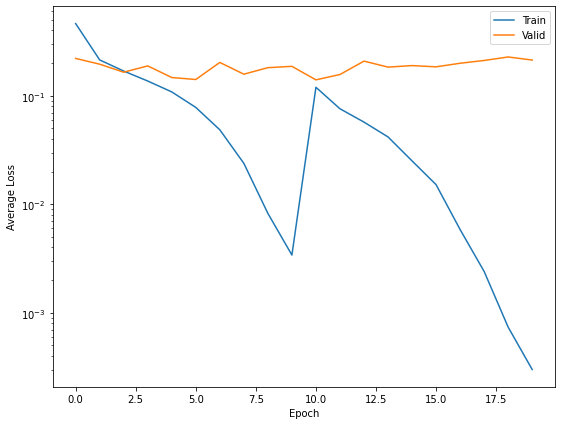

In [26]:
# # Plot losses
plt.figure(figsize=(9,7))
plt.semilogy(loss_dict['train_loss'], label='Train')
plt.semilogy(loss_dict['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

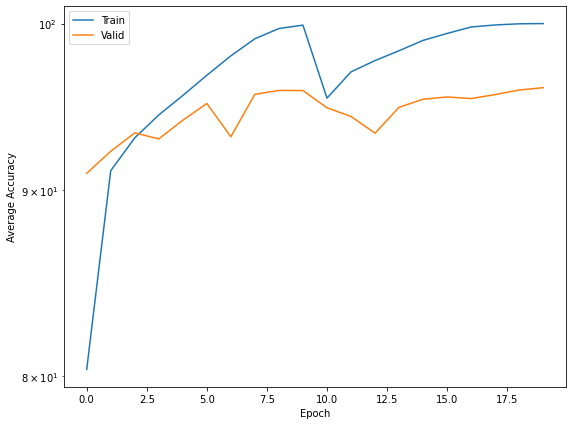

In [27]:
# Plot accuracy
plt.figure(figsize=(9,7))
plt.semilogy(acc_dict['train_accuracy'], label='Train')
plt.semilogy(acc_dict['val_accuracy'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [28]:
def test_epoch(model, dataloader,criterion):

    model.eval()
    test_loss = []
    test_accuracy = []
    
    y_pred_list = []
    y_pred_prob_list = []
    y_truth_list = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)
            y_truth_list.append(y_truth.detach().cpu().numpy())

            #forward prop
            y_pred = model(X)
            y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
            y_pred_prob_list.append(torch.softmax(y_pred, dim = 1).detach().cpu().numpy())
            _, y_pred_labels = torch.max(y_pred_softmax, dim = 1)
            y_pred_list.append(y_pred_labels.detach().cpu().numpy())

            #loss and accuracy calculation
            loss = criterion(y_pred, y_truth)
            accuracy = calculate_accuracy(y_pred, y_truth)


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            test_loss.append(loss.detach().cpu().numpy())
            test_accuracy.append(accuracy.detach().cpu().numpy())
            
    return y_pred_prob_list, y_pred_list, y_truth_list, np.mean(test_loss), np.mean(test_accuracy)

In [29]:
y_pred_prob_list, y_pred_list, y_truth_list, test_loss, test_accuracy = test_epoch(model, test_loader, criterion)

print(test_loss, test_accuracy)

  0%|          | 0/137 [00:00<?, ?it/s]

0.22624727 95.71533


In [30]:
def flatten_list(x):
    flattened_list = []
    for i in x:
        for j in i:
            flattened_list.append(j)
            
    return flattened_list

In [31]:
y_pred_list_flattened = flatten_list(y_pred_list)
y_truth_list_flattened = flatten_list(y_truth_list)
y_pred_prob_list_flattened = flatten_list(y_pred_prob_list)

In [32]:
idx2class = {v: k for k, v in train_dataset.class_map.items()}
class_names = [i for i in train_dataset.class_map.keys()]
idx2class

{0: 'axion', 1: 'no_sub', 2: 'cdm'}

In [33]:
print(classification_report(y_truth_list_flattened, y_pred_list_flattened,target_names = class_names))

              precision    recall  f1-score   support

       axion       0.93      0.96      0.95      2890
      no_sub       0.99      1.00      0.99      2886
         cdm       0.95      0.92      0.94      2977

    accuracy                           0.96      8753
   macro avg       0.96      0.96      0.96      8753
weighted avg       0.96      0.96      0.96      8753



In [34]:
print(confusion_matrix(y_pred_list_flattened, y_truth_list_flattened))

[[2766    0  197]
 [   0 2876   38]
 [ 124   10 2742]]


<AxesSubplot:>

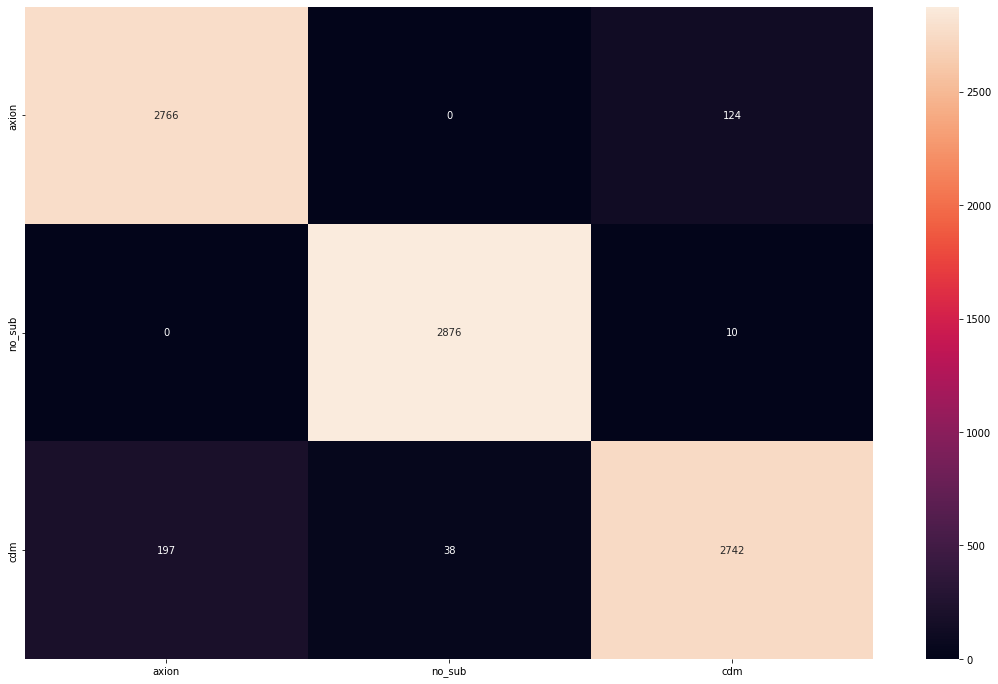

In [35]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_truth_list_flattened, y_pred_list_flattened)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(19,12))         
sns.heatmap(confusion_matrix_df, fmt = ".0f", annot=True, ax=ax)

In [36]:
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='macro', multi_class="ovr"))
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='macro', multi_class="ovo"))

0.9939028012961986
0.9939409311289807


In [37]:
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='weighted', multi_class="ovr"))
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='weighted', multi_class="ovo"))

0.9938527378489168
0.9939091847363397


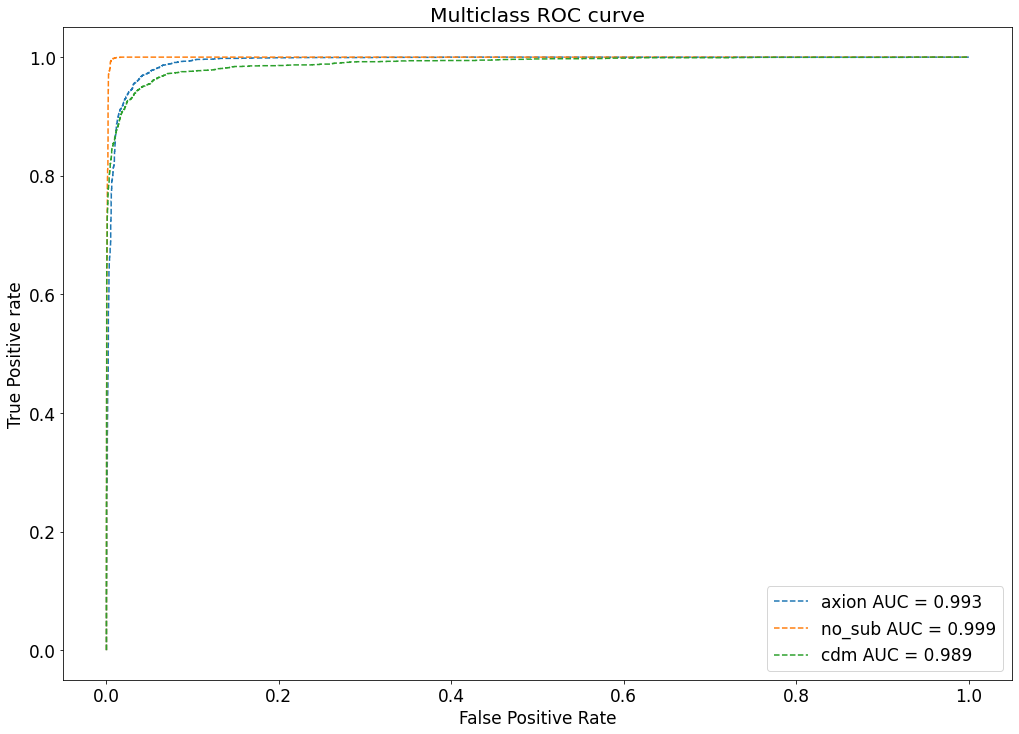

In [38]:
fpr = {}
tpr = {}
roc_auc = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(np.array(y_truth_list_flattened), np.array(y_pred_prob_list_flattened)[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(17,12))
plt.rcParams['font.size'] = '17'
for i in range(0,n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'{idx2class[i]} AUC = {roc_auc[i]:.3f}')

    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    
plt.savefig('CNN_Multiclass ROC full.png',dpi=352)